In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn as skl
import _pickle as pickle

from mylib import class_distributions
from mylib import data_selection
from mylib import helper_funcs

import dtreeviz
import logging
# to suppress messages when plotting trees
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
new_class_idx = 2
proportion_of_old_data = [0.1*i for i in range(1,10)]
num_models = 5
num_round = 10
num_round_update = [1,5,10]

In [3]:
# open file

data_folder = Path("../../../data/DryBeanDataset/")
model_folder = Path("../../../models/DryBeanDataset")
file_to_open = data_folder / "Dry_Bean_Dataset.xlsx"

In [4]:
# set the random seed for numpy
np.random.seed(42)

# define some paths
data_folder = Path("../../../data/DryBeanDataset/")
model_folder = Path("../../../models/DryBeanDataset")
file_to_open = data_folder / "Dry_Bean_Dataset.xlsx"


# read and prepare data
data = pd.read_excel(file_to_open)

labels_dict = {key:value for (value,key) in enumerate(data["Class"].unique())}
data["Class"] = data["Class"].map(labels_dict)

# need feature matrix X and labels labels for xgboost
labels = data["Class"]
X = data.drop(["Class"],axis=1,inplace=False)

In [70]:
class_distributions.label_proportions(labels)

5    0.260525
4    0.193667
0    0.148924
3    0.141650
2    0.119756
1    0.097127
6    0.038351
Name: Class, dtype: float64

In [6]:
# prepare smaller dataset with only first num_labels classes of beans
old_classes = np.delete(labels.unique(), new_class_idx)
new_class = new_class_idx

# compute number of old labels used
num_labels = len(old_classes)

# relabel for XGBoost
labels = helper_funcs.relabel(labels, old_classes, new_class)

# the "original" training data
data_small = X[labels < num_labels]
labels_small = labels[labels < num_labels]

# to check full model on all of the old data
dsmall = xgb.DMatrix(data_small, label=labels_small)

# attempt to retrain with new data
new_class_data = X[labels == num_labels]
new_class_labels = labels[labels == num_labels]

# only to check performance on the newly added data
dnew_class = xgb.DMatrix(new_class_data, label=new_class_labels)

# also train a model with all the data availale for comparison
data_full = pd.concat([data_small, new_class_data])
labels_full = pd.concat([labels_small, new_class_labels])

dfull = xgb.DMatrix(data_full, label=labels_full)

In [82]:
class_distributions.label_proportions(labels)

0.2605245757108221

In [7]:
num_round_full = 2*num_round   # here this is the fair comparison model

if num_round_update is None:
    num_round_update=[num_rounds]
max_depth = 3
eta = .1

# parameters for small model
param_small = {'max_depth': max_depth,
               'eta': eta,
               'objective': 'multi:softprob',
               "num_class": num_labels}
param_small['nthread'] = 4
param_small['eval_metric'] = 'mlogloss'

# parameters for update model (the same as for full model, but just in case I want to ever change them)
param_update = {'max_depth': max_depth,
                'eta': eta,
                'objective': 'multi:softprob',
                "num_class": num_labels+1}
param_update['nthread'] = 4
param_update['eval_metric'] = 'mlogloss'

# parameters for full model
param_full = {'max_depth': max_depth,
              'eta': eta,
              'objective': 'multi:softprob',
              "num_class": num_labels+1}
param_full['nthread'] = 4
param_full['eval_metric'] = 'mlogloss'

In [8]:
old_acc = np.zeros(num_models)
new_acc = np.zeros(num_models)
full_acc = np.zeros(num_models)

print("Training full models")
for model_num in range(num_models):
    
    # split data into train- and test-data
    seed = np.random.randint(0,100)
    X_train_full, X_test_full, y_train_full, y_test_full = skl.model_selection.train_test_split(data_full,
                                                                                                labels_full,
                                                                                                test_size=.2,
                                                                                                random_state=seed)

    dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full)
    dtest_full = xgb.DMatrix(X_test_full, label=y_test_full)
    
    evallist_full = [(dtrain_full, 'train'), (dtest_full, 'eval')]


    # training a model with all the training data
    bst_full = xgb.train(param_full,
                         dtrain_full,
                         num_round_full,
                         evals=evallist_full,
                         verbose_eval=False)
    
    old_acc[model_num] = skl.metrics.accuracy_score(np.argmax(bst_full.predict(dsmall), axis=1),
                                                     labels_small)
    new_acc[model_num] = skl.metrics.accuracy_score(np.argmax(bst_full.predict(dnew_class), axis=1),
                                                     new_class_labels)
    full_acc[model_num] = skl.metrics.accuracy_score(np.argmax(bst_full.predict(dtest_full), axis=1),
                                                     y_test_full)

print("Accuracy of full model on old data: ", old_acc.mean())
print("Accuracy of full model on new data: ", new_acc.mean())
print("Accuracy of full model on test data: ", full_acc.mean())

Training full models
Accuracy of full model on old data:  0.9171518068607227
Accuracy of full model on new data:  1.0
Accuracy of full model on test data:  0.9142122658832171


Current target proportion of old data in use: 0.1
Current target proportion of old data in use: 0.2
Current target proportion of old data in use: 0.30000000000000004
Current target proportion of old data in use: 0.4
Current target proportion of old data in use: 0.5
Current target proportion of old data in use: 0.6000000000000001
Current target proportion of old data in use: 0.7000000000000001
Current target proportion of old data in use: 0.8
Current target proportion of old data in use: 0.9


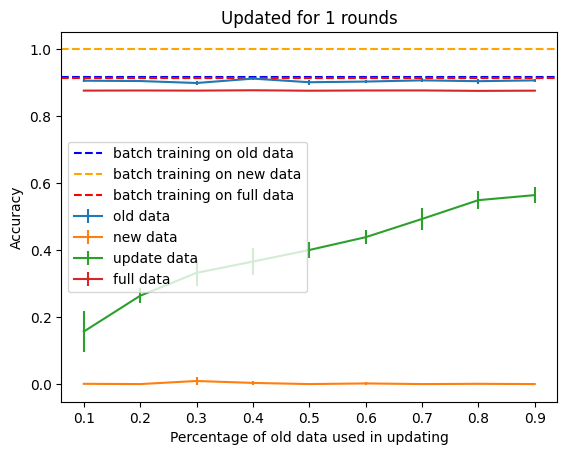

Current target proportion of old data in use: 0.1
Current target proportion of old data in use: 0.2
Current target proportion of old data in use: 0.30000000000000004
Current target proportion of old data in use: 0.4
Current target proportion of old data in use: 0.5
Current target proportion of old data in use: 0.6000000000000001
Current target proportion of old data in use: 0.7000000000000001
Current target proportion of old data in use: 0.8
Current target proportion of old data in use: 0.9


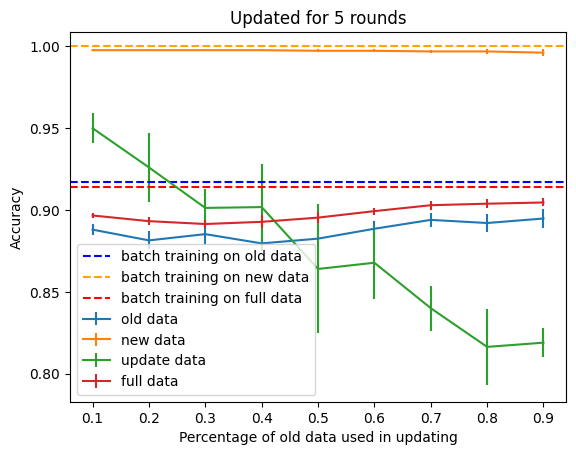

Current target proportion of old data in use: 0.1
Current target proportion of old data in use: 0.2
Current target proportion of old data in use: 0.30000000000000004
Current target proportion of old data in use: 0.4
Current target proportion of old data in use: 0.5
Current target proportion of old data in use: 0.6000000000000001
Current target proportion of old data in use: 0.7000000000000001
Current target proportion of old data in use: 0.8
Current target proportion of old data in use: 0.9


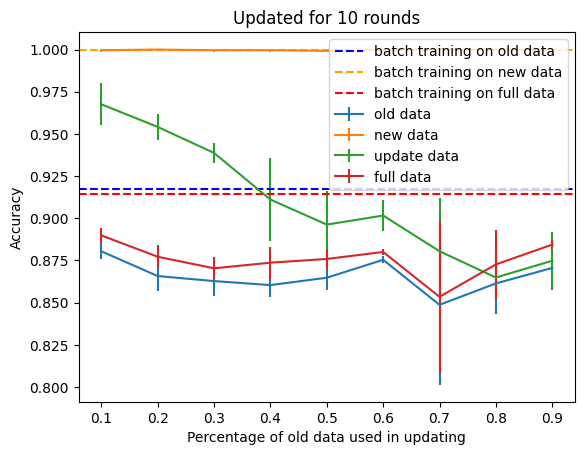

In [103]:
for plt_idx, num_round_updt in enumerate(num_round_update):

    critical_old_mean = np.zeros(len(proportion_of_old_data))
    critical_old_std = np.zeros(len(proportion_of_old_data))
    critical_new_mean = np.zeros(len(proportion_of_old_data))
    critical_new_std = np.zeros(len(proportion_of_old_data))
    critical_update_mean = np.zeros(len(proportion_of_old_data))
    critical_update_std = np.zeros(len(proportion_of_old_data))
    critical_full_mean = np.zeros(len(proportion_of_old_data))
    critical_full_std = np.zeros(len(proportion_of_old_data))

    for proportion_num, proportion in enumerate(proportion_of_old_data):
        print(f"Current target proportion of old data in use: {proportion}")
    
        critical_old_tmp = np.zeros(num_models)
        critical_new_tmp = np.zeros(num_models)
        critical_update_tmp = np.zeros(num_models)
        critical_full_tmp = np.zeros(num_models)
    
        for model_num in range(num_models):
    
            # training model with fewer labels
            seed = np.random.randint(0,100)
            # split original data into train- and test-data
            X_train_small, X_test_small, y_train_small, y_test_small = skl.model_selection.train_test_split(data_small, 
                                                                                                            labels_small,
                                                                                                            test_size=.2,
                                                                                                            random_state=seed)
    
            # specify DMatrices
            dtrain_small = xgb.DMatrix(X_train_small, label=y_train_small)
            dtest_small = xgb.DMatrix(X_test_small, label=y_test_small)
            
            evallist_small = [(dtrain_small, 'train'), (dtest_small, 'eval')]
            
            bst_small = xgb.train(param_small,
                                  dtrain_small,
                                  num_round,
                                  evals=evallist_small,
                                  verbose_eval=False)
    
            bst_small.save_model(fname=model_folder / 'small_model.json')
            bst_small_df = bst_small.trees_to_dataframe()

            # compute important features in model
            important_features = data_selection.important_features_by_class(bst_small_df, num_labels, criterion="gain")
            
            # data selection
            critical_data = pd.DataFrame(dtype='float64')
            critical_data_labels = pd.Series(dtype='int8')
            
            for (label, feature, split_val) in important_features:
                tmp, tmp_labels = data_selection.get_samples_split_value(data_small,
                                                                      labels_small,
                                                                      feature,
                                                                      split_val,
                                                                      label,
                                                                      ratio_return_total=proportion/num_labels,
                                                                      sort_type="closest")
                
                critical_data = pd.concat([critical_data, tmp])
                critical_data_labels = pd.concat([critical_data_labels, tmp_labels])
            
            data_update = pd.concat([pd.DataFrame(critical_data), new_class_data])
            labels_update = pd.concat([pd.DataFrame(critical_data_labels), new_class_labels])
            
            seed = np.random.randint(0,100)
            X_train_update, X_test_update, y_train_update, y_test_update = skl.model_selection.train_test_split(data_update,
                                                                                                                labels_update,
                                                                                                                test_size=.2,
                                                                                                                random_state=seed)

    
            # create DMatrices
    
            dtrain_update = xgb.DMatrix(X_train_update, label=y_train_update)
            dtest_update = xgb.DMatrix(X_test_update, label=y_test_update)
    
            evallist_update = [(dtrain_update, 'train'), (dtest_update, 'eval')]
            
            # update model
            bst_update = xgb.train(param_update,
                                  dtrain_update,
                                  num_round_updt,
                                  evals=evallist_update,
                                  #early_stopping_rounds=early_stopping_rounds,
                                  verbose_eval=False,
                                  xgb_model=model_folder/"small_model.json")
    
            
            critical_old_tmp[model_num] = skl.metrics.accuracy_score(np.argmax(bst_update.predict(dtest_small), axis=1),
                                                                   y_test_small)
            critical_new_tmp[model_num] = skl.metrics.accuracy_score(np.argmax(bst_update.predict(dnew_class), axis=1),
                                                                   new_class_labels)
            critical_update_tmp[model_num] = skl.metrics.accuracy_score(np.argmax(bst_update.predict(dtest_update), axis=1),
                                                                     y_test_update)
            critical_full_tmp[model_num] = skl.metrics.accuracy_score(np.argmax(bst_update.predict(dfull), axis=1),
                                                                    labels_full)
    
        critical_old_mean[proportion_num] = critical_old_tmp.mean()
        critical_old_std[proportion_num] = critical_old_tmp.std()
        critical_new_mean[proportion_num] = critical_new_tmp.mean()
        critical_new_std[proportion_num] = critical_new_tmp.std()
        critical_update_mean[proportion_num] = critical_update_tmp.mean()
        critical_update_std[proportion_num] = critical_update_tmp.std()  
        critical_full_mean[proportion_num] = critical_full_tmp.mean()
        critical_full_std[proportion_num] = critical_full_tmp.std()

    
    plt.errorbar(proportion_of_old_data,
         critical_old_mean,
         yerr=critical_old_std,
         label="old data")

    plt.errorbar(proportion_of_old_data,
             critical_new_mean,
             yerr=critical_new_std,
             label="new data")
    
    plt.errorbar(proportion_of_old_data,
             critical_update_mean,
             yerr=critical_update_std,
             label="update data")
    
    plt.errorbar(proportion_of_old_data,
             critical_full_mean,
             yerr=critical_full_std,
             label="full data")
    
    plt.axhline(old_acc.mean(),
            color = "blue",
            linestyle = "--",
            label = "batch training on old data")
    
    plt.axhline(new_acc.mean(),
            color = "orange",
            linestyle = "--",
            label = "batch training on new data")
    
    plt.axhline(full_acc.mean(),
            color = "red",
            linestyle = "--",
            label = "batch training on full data")
    
    plt.xlabel("Percentage of old data used in updating")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Updated for {num_round_updt} rounds")
    plt.show();

In [94]:
# create dataframe of original (i.e. small) model

bst_small_df=bst_small.trees_to_dataframe()
roots = bst_small_df[bst_small_df["Node"]==0]

important_features_roots = data_selection.important_features_by_class(roots, num_labels, criterion="gain")
important_features_all_splits = data_selection.important_features_by_class(bst_small_df, num_labels, criterion="gain")